# Radar Classification by CNN

#### **NOTE：** You can also visit https://www.kaggle.com/code/alextheocharous/radar-classification-cnn/edit/run/182880794 to run the code directly.

## Data Processing

In [1]:
import os
class_names=os.listdir('/kaggle/input/radar-data-cfar/image_data_cfar/image_data')
print(class_names)

['stand', 'drink', 'walk', 'sit', 'fall', 'pick']


In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

2024-06-11 19:13:12.795233: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 19:13:12.795370: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 19:13:12.925404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import matplotlib.pyplot as plt
 
import itertools
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
# %matplotlib inline  
# style.use('fivethirtyeight')
# sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# specifically for cnn
from tensorflow.keras.layers import Dropout, Flatten,Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [4]:
X=[]
Z=[]
IMG_SIZE=256
WALK_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/walk'
FALL_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/fall'
DRINK_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/drink'
PICK_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/pick'
SIT_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/sit'
STAND_DIR='/kaggle/input/radar-data-cfar/image_data_cfar/image_data/stand'


In [5]:
def assign_label(img,movement_type):
    return movement_type

In [6]:
def make_train_data(movement_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,movement_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        img = np.array(img)

#         img[:, :, 2] = 0
#         img[:, :, 1] = 0
#         img[:, :, 0] = 0
        
        #1: DR 0:RT 2: DT
        
        X.append(img)
        Z.append(str(label))

In [7]:
make_train_data('walk',WALK_DIR)
make_train_data('fall',FALL_DIR)
make_train_data('drink',DRINK_DIR)
make_train_data('pick',PICK_DIR)
make_train_data('sit',SIT_DIR)
make_train_data('stand',STAND_DIR)

100%|██████████| 287/287 [00:01<00:00, 150.36it/s]


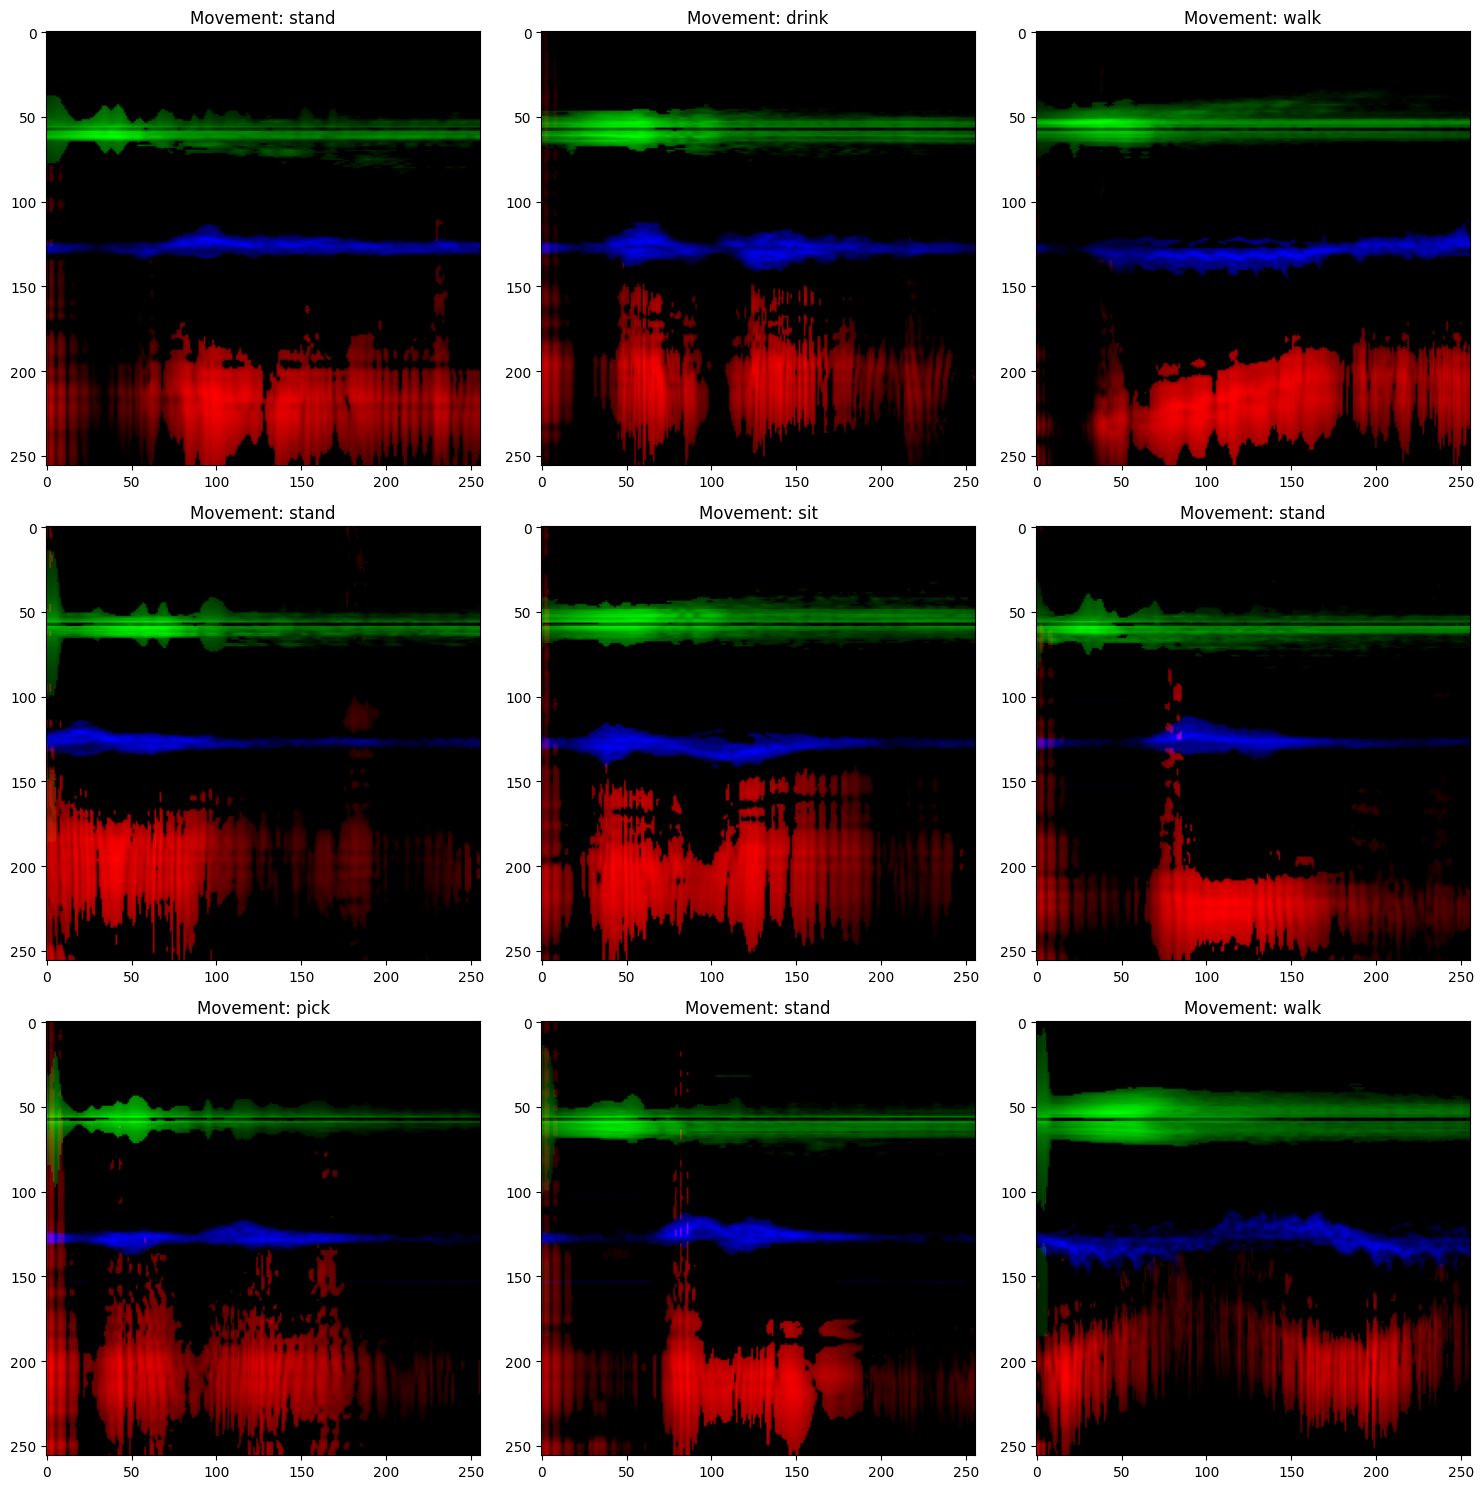

In [8]:
fig,ax=plt.subplots(3,3)
fig.set_size_inches(15,15)
for i in range(3):
    for j in range (3):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Movement: '+Z[l])
        
plt.tight_layout()

In [9]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,6)
X=np.array(X)
X=X/255

In [10]:
x_data,x_val,y_data,y_val=train_test_split(X,Y,test_size=0.2,random_state=42)
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.2,random_state=42)

np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## CNN Model Construction

In [11]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Dropout(0.4))



model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dense(128))
# model.add(Activation('relu'))
model.add(Dense(6, activation = "softmax"))

In [12]:
batch_size=128
epochs=75

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

def scheduler(epoch, lr):
     if epoch < 25:
         return lr
     else:
         return lr * np.exp(-0.1)
    
from tensorflow.keras.callbacks import LearningRateScheduler
callback = LearningRateScheduler(scheduler)

In [13]:
datagen = ImageDataGenerator()

datagen.fit(x_train)

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 600,358 (2.29 MB)

 Trainable params: 600,358 (2.29 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [15]:
checkpoint = ModelCheckpoint('model/training_{epoch:02d}.keras',  # Model file name with epoch number
                             save_best_only=True,          # Set to True to save only the best model
                             save_weights_only=False,       # Set to True to save only the weights
                             monitor='val_accuracy',            # Metric to monitor
                             mode='auto',                   # Mode to decide whether to minimize or maximize the monitored metric
                             verbose=1)                     # Verbosity mode

# Fit the model with the checkpoint callback
History = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=epochs,
                              validation_data=(x_val, y_val),
                              verbose=1,
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[checkpoint, callback])

Epoch 1/75


2024-06-11 19:14:06.763099: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,128,128]{3,2,1,0}, f32[128,64,128,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-11 19:14:07.311793: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.548800428s
Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,32,128,128]{3,2,1,0}, f32[128,64,128,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-11 19:14:09.182426: E exter

1/8 ━━━━━━━━━━━━━━━━━━━━ 3:30 30s/step - accuracy: 0.1250 - loss: 1.7935

I0000 00:00:1718133253.917072     138 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1836 - loss: 1.7642   
Epoch 1: val_accuracy improved from -inf to 0.53659, saving model to model/training_01.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.1874 - loss: 1.7604 - val_accuracy: 0.5366 - val_loss: 1.4409 - learning_rate: 0.0010
Epoch 2/75
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5391 - loss: 1.4406
Epoch 2: val_accuracy improved from 0.53659 to 0.58232, saving model to model/training_02.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5391 - loss: 1.4406 - val_accuracy: 0.5823 - val_loss: 1.3119 - learning_rate: 0.0010
Epoch 3/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5563 - loss: 1.1836
Epoch 3: val_accuracy improved from 0.58232 to 0.77744, saving model to model/training_03.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.5602 - loss: 1.1708 - val_accuracy: 0.7774 - val_loss: 0.6468 - learning_rate: 0.0010
Epoch 4/75
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy

## Evaluation

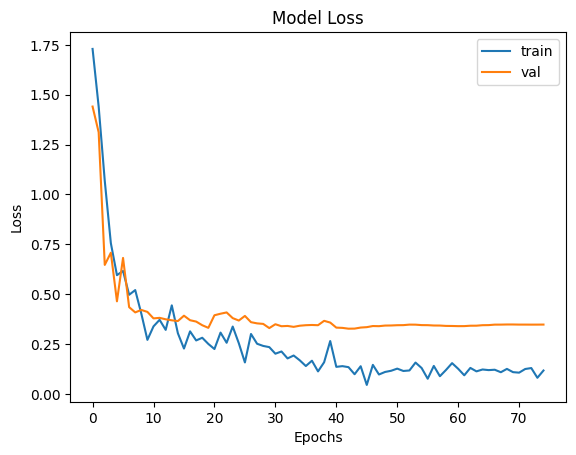

In [16]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

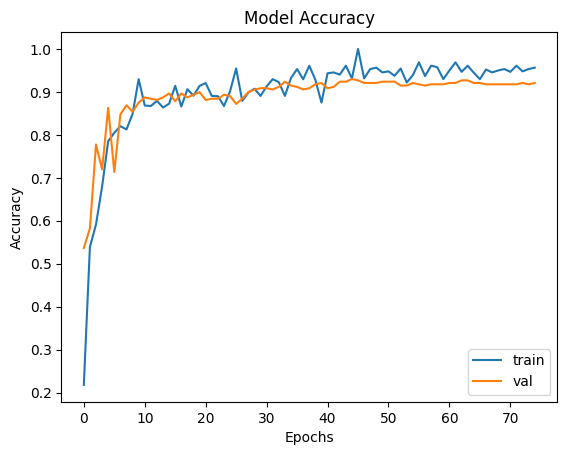

In [17]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [25]:
# model = load_model('/kaggle/input/radar-classification-cnn/tensorflow2/radar-classification-cnn/1/model_best_cnn (1).keras')   #Uncomment to use the trained model
model.evaluate(x_train,y_train)
model.evaluate(x_val,y_val)
model.evaluate(x_test, y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9596 - loss: 0.0967
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9084 - loss: 0.3414
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9501 - loss: 0.1849


[0.1665196418762207, 0.9427480697631836]

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


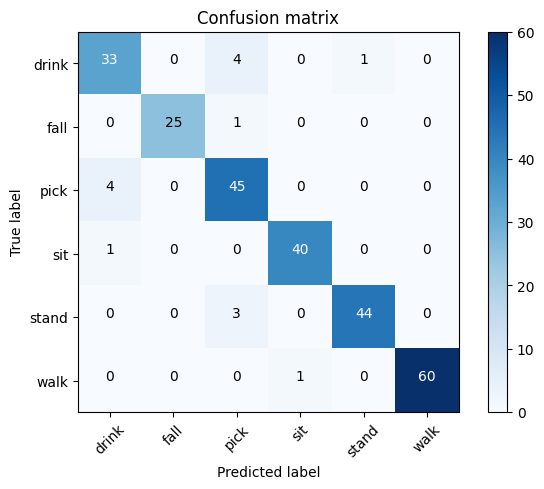

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
activity=['drink','fall','pick','sit','stand','walk']
plot_confusion_matrix(confusion_mtx, classes = activity ) 

In [20]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


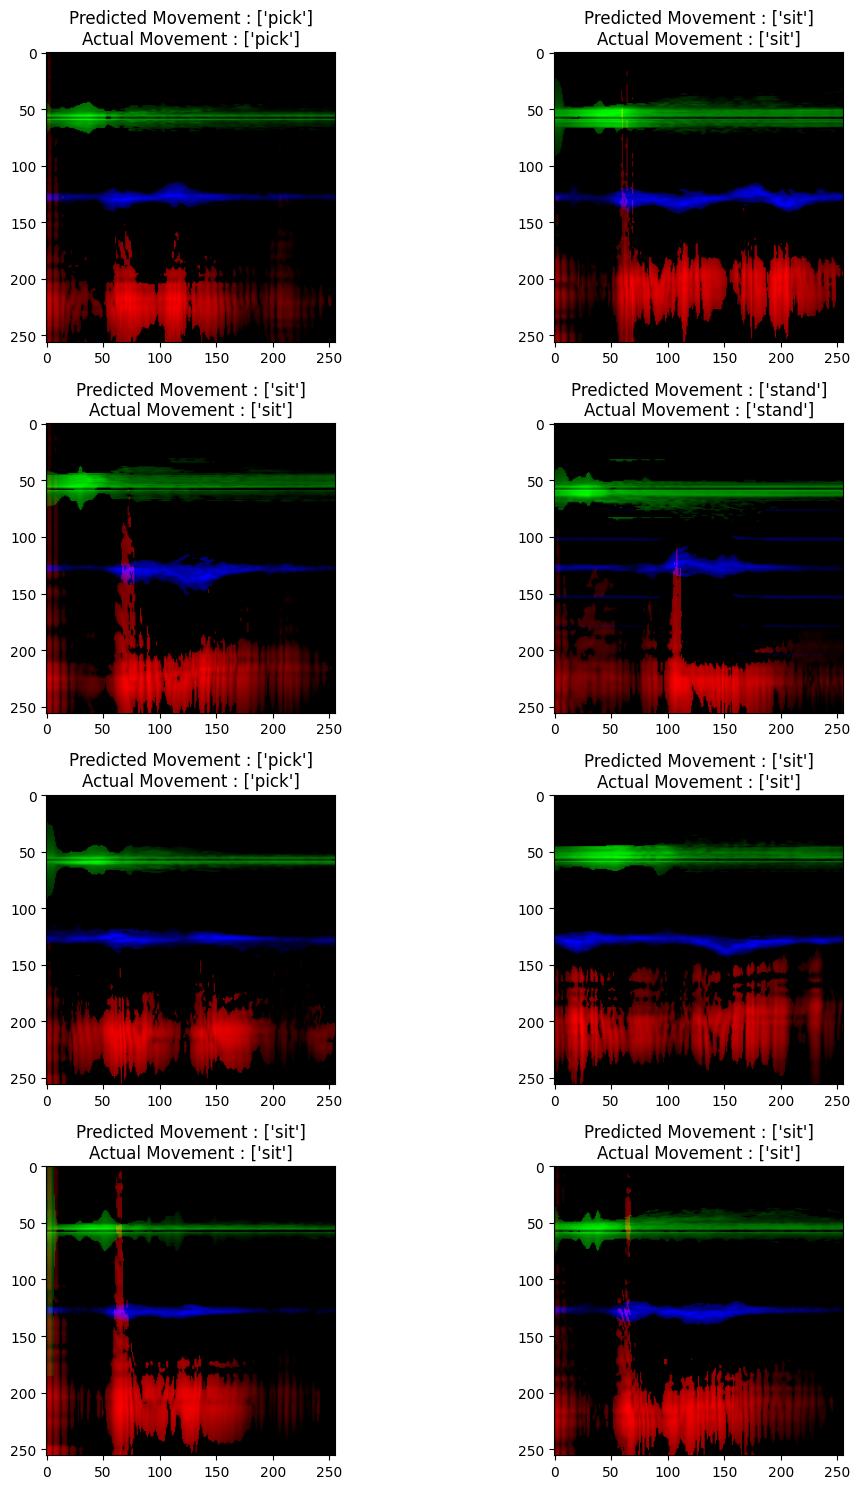

In [21]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Movement : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Movement : "+str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

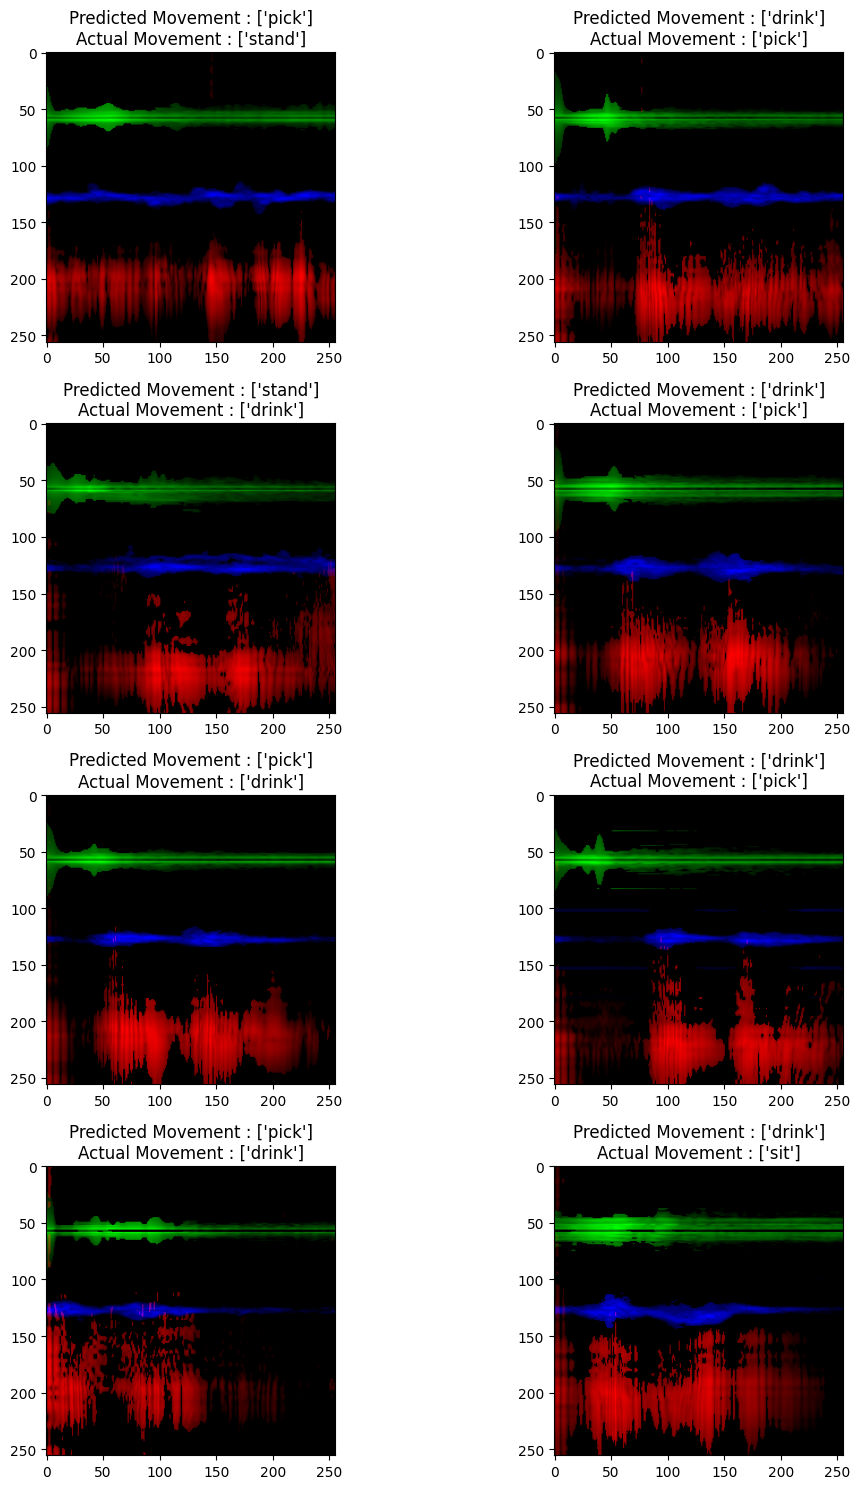

In [22]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Movement : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Movement : "+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

In [24]:
# !mkdir -p saved_model
# model.save('saved_model/model_best_cnn.keras')